**Toxicity Detection in Online Comments**

Have you ever felt upset after reading toxic comments on the Internet?

Our project is dedicated to detect toxicity in online comments.
Nowadays, the Internet is filled with hatred and anger people share with each other, and even though the platforms try to moderate them, it is still not enough. It can cause different mental problems of people being hated on different social media and sometimes cause some irreversable consequences.

In [1]:
#loading libraries that will be used later
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re
from datasets import load_dataset

In [2]:
#getting the dataset from hugging face
ds = load_dataset("dirtycomputer/Toxic_Comment_Classification_Challenge")

train.csv:   0%|          | 0.00/68.8M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/60.4M [00:00<?, ?B/s]

test_labels.csv: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [3]:
df = ds['train'].to_pandas() #so we will be able to do EDA and cleaning without any problems
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Exploratory Data Analysis

In [4]:
df.info() #getting the info of dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [5]:
print("Rows:", df.shape[0]) #num of rows
print("Columns:", df.shape[1]) #num of columns
print(df.isnull().sum()) #checking for null values

Rows: 159571
Columns: 8
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [6]:
df = df.drop_duplicates(subset="comment_text") #deleting duplicates
df.shape

(159571, 8)

Checking the word count for all comments.

In [7]:
df = df.copy()
df["word_count"] = df["comment_text"].str.split().str.len()

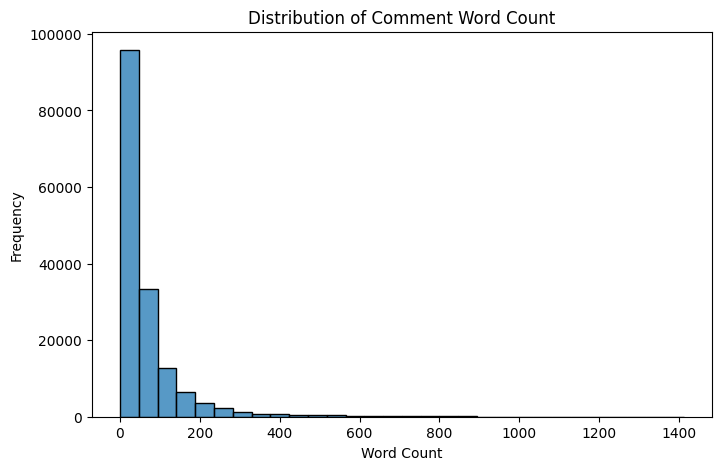

In [8]:
plt.figure(figsize=(8,5))
sns.histplot(df["word_count"], bins=30)
plt.title("Distribution of Comment Word Count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show() #plotting the figure for better understanding

We can see that the majority of comments have few words, less than 100. We can assume that the majority of people write very few words in the comments, however there are still outliers who wrote up to 1400 words.

Cleaning

In [9]:
def clean_text(text):
    text = text.lower() #lowercase
    text = re.sub(r"[^a-zA-Z ]","", text) #deleting the unnecessary symbols
    return text

df["comment_text"] = df["comment_text"].apply(clean_text)
df.drop(columns=['id'], inplace=True)
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,word_count
0,explanationwhy the edits made under my usernam...,0,0,0,0,0,0,43
1,daww he matches this background colour im seem...,0,0,0,0,0,0,17
2,hey man im really not trying to edit war its j...,0,0,0,0,0,0,42
3,morei cant make any real suggestions on improv...,0,0,0,0,0,0,113
4,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,13


**USING THE TOXICITY DETECTION MODEL ON HUGGING FACE**

Hugging Face

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

model_name = "HyperX-Sentience/RogueBERT-Toxicity-85K" #using this model

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    truncation=True
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [11]:
df_small = df.head(20000)
def get_toxicity_scores(text):
    scores = pipe(text)[0]
    return {s["label"]: s["score"] for s in scores}
tox_df = df_small["comment_text"].apply(get_toxicity_scores).apply(pd.Series)
df_small = pd.concat([df_small["comment_text"], tox_df], axis=1)
df_small.head()

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,comment_text,LABEL_0,LABEL_1,LABEL_2,LABEL_3,LABEL_4,LABEL_5
0,explanationwhy the edits made under my usernam...,0.001114,0.000113,0.000404,0.000088,0.000306,0.000202
1,daww he matches this background colour im seem...,0.000798,0.000150,0.000389,0.000111,0.000307,0.000236
2,hey man im really not trying to edit war its j...,0.001067,0.000117,0.000397,0.000090,0.000302,0.000204
3,morei cant make any real suggestions on improv...,0.000958,0.000126,0.000399,0.000094,0.000301,0.000209
4,you sir are my hero any chance you remember wh...,0.001007,0.000123,0.000383,0.000094,0.000302,0.000212


In [12]:
df_small.rename(columns={"LABEL_0": "toxic", 'LABEL_1': 'severe_toxic', 'LABEL_2': 'obscene', 'LABEL_3': 'threat', 'LABEL_4': 'insult', 'LABEL_5': 'identity_hate'}, inplace=True)
df_small.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanationwhy the edits made under my usernam...,0.001114,0.000113,0.000404,0.000088,0.000306,0.000202
1,daww he matches this background colour im seem...,0.000798,0.000150,0.000389,0.000111,0.000307,0.000236
2,hey man im really not trying to edit war its j...,0.001067,0.000117,0.000397,0.000090,0.000302,0.000204
3,morei cant make any real suggestions on improv...,0.000958,0.000126,0.000399,0.000094,0.000301,0.000209
4,you sir are my hero any chance you remember wh...,0.001007,0.000123,0.000383,0.000094,0.000302,0.000212


In [14]:
tox_cat = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
threshold = 0.8 #We got this threshold from articles used for Toxicity Detection, such as https://communalytic.org/docs/tutorial-toxicity-analysis/#:~:text=Step%208,Toxicity%20Analysis%20tool%20for%20yourself!

df_binary = (df_small[tox_cat] >= threshold).astype(int)
df_binary.head(10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,1,0,1,0,1,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


In [17]:
df=df.head(20000)
labels = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
labels = df.columns[1:]
df_true = df[labels]
df_pred = df_binary[labels]
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = {}

for label in labels:
    y_true = df_true[label]
    y_pred = df_pred[label]

    results[label] = {
        "accuracy": accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred)
    }

results


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'toxic': {'accuracy': 0.9672,
  'precision': 0.8938377059182429,
  'recall': 0.7524396507447355,
  'f1_score': 0.8170663692136084},
 'severe_toxic': {'accuracy': 0.9889,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 'obscene': {'accuracy': 0.98255,
  'precision': 0.8973799126637555,
  'recall': 0.7632311977715878,
  'f1_score': 0.8248871048670346},
 'threat': {'accuracy': 0.99665,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 'insult': {'accuracy': 0.9742,
  'precision': 0.8463648834019204,
  'recall': 0.604309500489716,
  'f1_score': 0.7051428571428572},
 'identity_hate': {'accuracy': 0.99245,
  'precision': 0.875,
  'recall': 0.19337016574585636,
  'f1_score': 0.3167420814479638}}

In [18]:
from sklearn.metrics import confusion_matrix

for label in labels:
    print(f"\nConfusion matrix for: {label}")
    print(confusion_matrix(df_true[label], df_pred[label]))



Confusion matrix for: toxic
[[17879   174]
 [  482  1465]]

Confusion matrix for: severe_toxic
[[19778     0]
 [  222     0]]

Confusion matrix for: obscene
[[18829    94]
 [  255   822]]

Confusion matrix for: threat
[[19933     0]
 [   67     0]]

Confusion matrix for: insult
[[18867   112]
 [  404   617]]

Confusion matrix for: identity_hate
[[19814     5]
 [  146    35]]


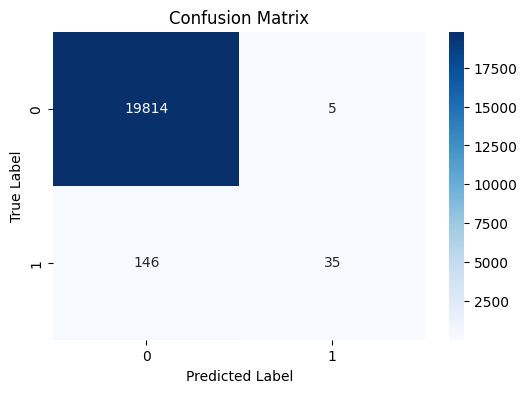

In [19]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

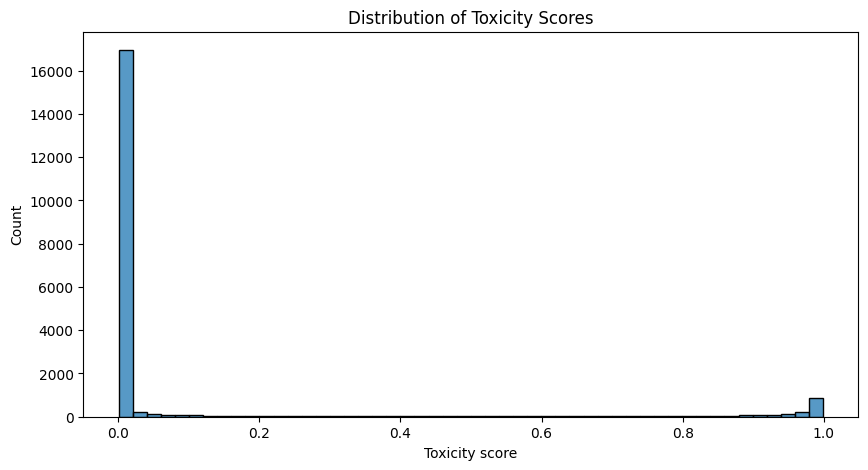

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(df_small["toxic"], bins=50)
plt.title("Distribution of Toxicity Scores")
plt.xlabel("Toxicity score")
plt.ylabel("Count")
plt.show()

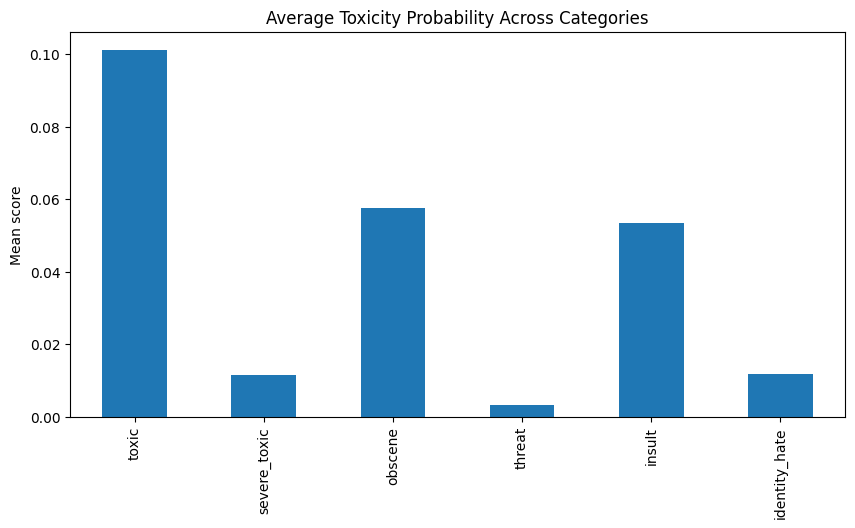

In [21]:
tox_cat = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

df_small[tox_cat].mean().plot(kind="bar", figsize=(10,5))
plt.title("Average Toxicity Probability Across Categories")
plt.ylabel("Mean score")
plt.show()

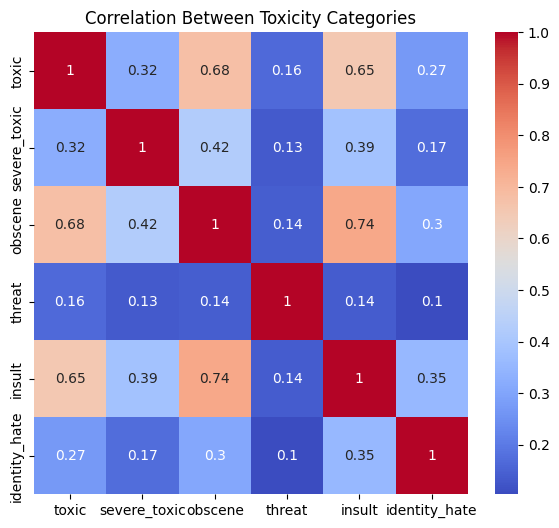

In [22]:
plt.figure(figsize=(7,6))
sns.heatmap(df[tox_cat].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Toxicity Categories")
plt.show()

ANOTHER MODEL COMPARISON

In [23]:
model_name = "Unitary/toxic-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    truncation=True
)

tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [25]:
df_small = df.head(20000)
def get_toxicity_scores(text):
    scores = pipe(text)[0]
    return {s["label"]: s["score"] for s in scores}
tox_df = df_small["comment_text"].apply(get_toxicity_scores).apply(pd.Series)
df_small = pd.concat([df_small["comment_text"], tox_df], axis=1)
df_small.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanationwhy the edits made under my usernam...,0.006119,0.000090,0.000469,0.000130,0.000370,0.000163
1,daww he matches this background colour im seem...,0.000992,0.000101,0.000182,0.000120,0.000191,0.000137
2,hey man im really not trying to edit war its j...,0.002372,0.000089,0.000246,0.000111,0.000215,0.000149
3,morei cant make any real suggestions on improv...,0.000720,0.000114,0.000182,0.000136,0.000182,0.000136
4,you sir are my hero any chance you remember wh...,0.002011,0.000096,0.000193,0.000165,0.000231,0.000166


In [26]:
df_binary1 = (df_small[tox_cat] >= threshold).astype(int)
df_binary1.head(10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,1,0,1,0,1,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


In [27]:
df_true = df[labels]
df_pred = df_binary1[labels]

results1 = {}

for label in labels:
    y_true = df_true[label]
    y_pred = df_pred[label]

    results1[label] = {
        "accuracy": accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred)
    }

results1

{'toxic': {'accuracy': 0.97385,
  'precision': 0.9517766497461929,
  'recall': 0.7704160246533128,
  'f1_score': 0.8515469770082317},
 'severe_toxic': {'accuracy': 0.98895,
  'precision': 0.5384615384615384,
  'recall': 0.03153153153153153,
  'f1_score': 0.059574468085106386},
 'obscene': {'accuracy': 0.9857,
  'precision': 0.9294245385450597,
  'recall': 0.7948003714020427,
  'f1_score': 0.8568568568568569},
 'threat': {'accuracy': 0.998,
  'precision': 0.8292682926829268,
  'recall': 0.5074626865671642,
  'f1_score': 0.6296296296296297},
 'insult': {'accuracy': 0.979,
  'precision': 0.8808618504435995,
  'recall': 0.6807051909892262,
  'f1_score': 0.7679558011049724},
 'identity_hate': {'accuracy': 0.99465,
  'precision': 0.8854166666666666,
  'recall': 0.4696132596685083,
  'f1_score': 0.6137184115523465}}

In [28]:
for label in labels:
    print(f"\nConfusion matrix for: {label}")
    print(confusion_matrix(df_true[label], df_pred[label]))



Confusion matrix for: toxic
[[17977    76]
 [  447  1500]]

Confusion matrix for: severe_toxic
[[19772     6]
 [  215     7]]

Confusion matrix for: obscene
[[18858    65]
 [  221   856]]

Confusion matrix for: threat
[[19926     7]
 [   33    34]]

Confusion matrix for: insult
[[18885    94]
 [  326   695]]

Confusion matrix for: identity_hate
[[19808    11]
 [   96    85]]


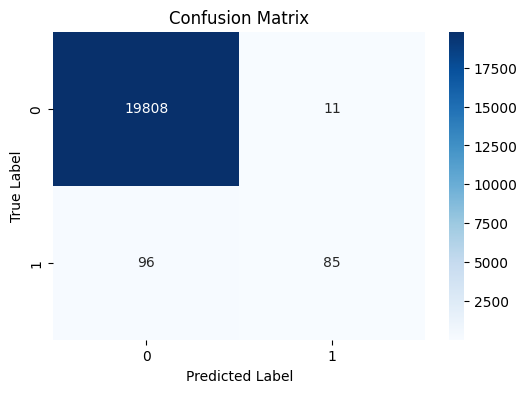

In [30]:
cm1 = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [35]:
df_results1 = pd.DataFrame(results).T
df_results2 = pd.DataFrame(results1).T
comparison_table = pd.concat([df_results1, df_results2], axis=1)
comparison_table

,accuracy,precision,recall,f1_score,accuracy,precision,recall,f1_score
toxic,0.96720,0.893838,0.752440,0.817066,0.97385,0.951777,0.770416,0.851547
severe_toxic,0.98890,0.000000,0.000000,0.000000,0.98895,0.538462,0.031532,0.059574
obscene,0.98255,0.897380,0.763231,0.824887,0.98570,0.929425,0.794800,0.856857
threat,0.99665,0.000000,0.000000,0.000000,0.99800,0.829268,0.507463,0.629630
insult,0.97420,0.846365,0.604310,0.705143,0.97900,0.880862,0.680705,0.767956
identity_hate,0.99245,0.875000,0.193370,0.316742,0.99465,0.885417,0.469613,0.613718


CONSLUSION:
We decided that the toxic-bert model is the perfect fit for our project because of its high accuracy compared to other models.

We hope that our project can be an addition to social medias, especially YouTube. Our idea is to use this method as a quality assessments for videos on YouTube, and viewers can see the toxicity of comments in advance and decide for themselves if the video worth their time.